In [1]:
import numpy as np
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os, glob
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

sns.set_theme()

# testdrive

it's just a simple testfile to stitch everything together

In [2]:
DATADIR = os.path.join(os.getcwd(), "data")
ZIPDIR = os.path.join(os.getcwd(), "data/zip")
SAMPLE_RATE = 100_000_000

## step 1
figure out how to extract data from the zipfiles,
label them, and then put them into a format suitable for further ML

### step 1.1
extract all the zipfiles and obtain our raw iq and ifft files

In [ ]:
def unload_zip_files(zipdir, extractdir) -> None:
    """unload zip files in the respective zip directory"""
    # list filenames that end with .zip
    pattern = os.path.join(zipdir, "**", "*.zip")
    zipfiles = glob.glob(pattern, recursive=True)

    # unzip all zipfiles found
    for zfile in zipfiles:
        try:
            with zipfile.ZipFile(zfile, "r") as zip_ref:
                zip_ref.extractall(extractdir)
            print(
                f"Successfully extracted all files from '{zipdir}' to '{extractdir}'."
            )
        except zipfile.BadZipFile:
            print(f"Error: '{zfile}' is not a valid ZIP file.")
        except FileNotFoundError:
            print(f"Error: The file '{zfile}' was not found.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")


for _ in tqdm(range(100)):
    unload_zip_files(ZIPDIR, DATADIR)

### step 1.2 
come up with helper functions to
* read a raw IFFT file
* compute its Welch PSD
* compute its STFT (short-term Fourier transform)
<!-- read the raw ifft file given some dataformat and the filepath -->

In [4]:
def read_raw_ifft(file_path, data_format):
    """
    read raw binary data from file and return as numpy array after IFFT
    """
    # Map format strings to numpy dtypes and struct formats
    format_map = {
        "float32": (np.float32, "f"),
        "float64": (np.float64, "d"),
        "int16": (np.int16, "h"),
        "int32": (np.int32, "i"),
        "complex64": (np.complex64, None),  # Special handling for complex
        "complex128": (np.complex128, None),
    }

    if data_format not in format_map:
        raise ValueError(f"Unsupported data format: {data_format}")

    try:
        with open(file_path, "rb") as f:
            raw_data = f.read()

        # handle complex data (interleaved real/imaginary)
        if data_format in ["complex64", "complex128"]:
            # each complex number is 2 float32 values
            float_data = np.frombuffer(
                raw_data,
                dtype=(np.float32 if data_format == "complex64" else np.float64),
            )
            data = float_data[::2] + 1j * float_data[1::2]
        else:
            # Handle real data types
            dtype, _ = format_map[data_format]
            data = np.frombuffer(raw_data, dtype=dtype)

        return data

    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {file_path}")
    except Exception as e:
        raise RuntimeError(f"Error reading file: {str(e)}")

In [5]:
test_ifft = read_raw_ifft(
    "data/DataCollection_HCJCTrack_110925/Aquila16_Ifft_150m_1_40_40_01/sweep/3.ifft",
    "float64",
)

In [6]:
def compute_stft(iq_data, sample_rate_hz, nperseg=8192, visualise=False):
    """
    computes the short-time fourier transform of the given IQ data
    """
    f, t, Zxx = signal.stft(
        iq_data,
        fs=sample_rate_hz,
        nperseg=nperseg,
        return_onesided=False,  # Two-sided spectrum
    )

    # Shift frequencies to center around 0 Hz
    f = np.fft.fftshift(f)
    Zxx = np.fft.fftshift(Zxx, axes=0)

    if visualise:
        print("Plotting STFT")
        plt.figure(figsize=(12, 8))
        plt.pcolormesh(t, f / 1e6, np.abs(Zxx), shading="gouraud")
        plt.title("Short-Time Fourier Transform (STFT)")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [MHz]")
        plt.colorbar(label="Magnitude")
        plt.grid(True)
        plt.show()

    return f, t, Zxx

Plotting STFT


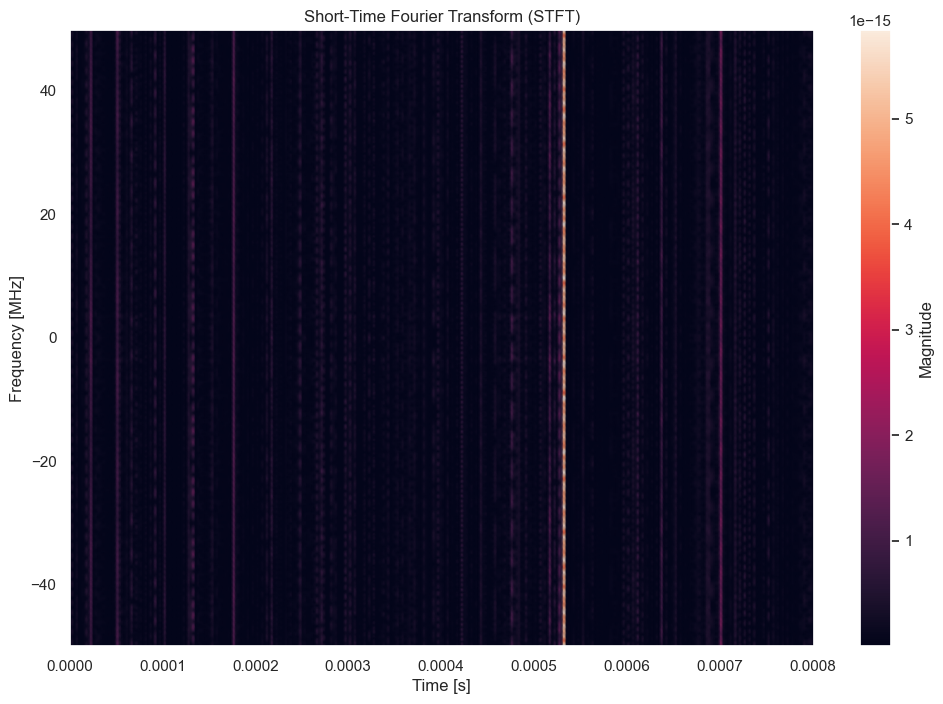

In [7]:
f_, t_, Zxx_ = compute_stft(test_ifft, SAMPLE_RATE, nperseg=512, visualise=True)

In [8]:
def compute_welch_psd(
    iq_data, sample_rate_hz, window="hann", nperseg=8192, visualise=False
):
    """
    Compute the Welch power spectral density (PSD) of the IQ data.
    """
    f, Pxx = signal.welch(iq_data, fs=sample_rate_hz, nperseg=nperseg, window=window)

    if visualise:
        print("Plotting wPSD")
        plt.figure(figsize=(12, 8))
        plt.semilogy(f, Pxx)
        plt.title("Welch's Power Spectral Density (wPSD)")
        plt.xlabel("Frequency [MHz]")
        plt.ylabel("Power [V2/Hz]")
        plt.show()

    return f, Pxx

Plotting wPSD


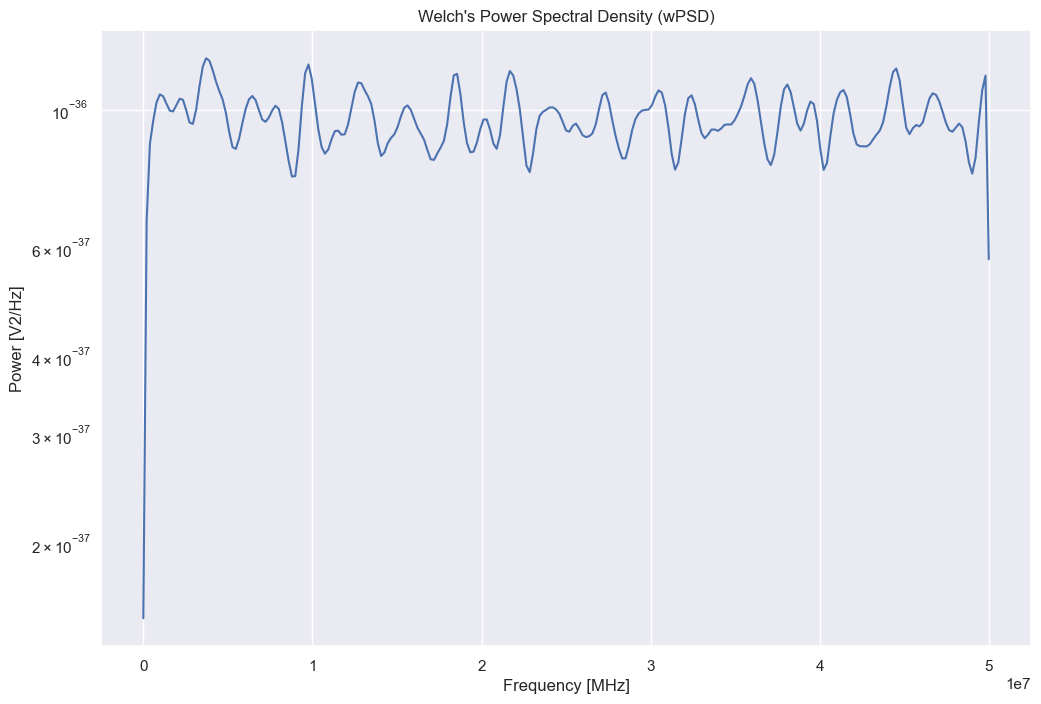

In [9]:
f_test, Pxx_test = compute_welch_psd(
    iq_data=test_ifft,
    sample_rate_hz=SAMPLE_RATE,
    nperseg=512,
    visualise=True,
)

## step 1.3
create a `pandas.DataFrame` that contains
- the PSD and STFT of each IFFT sweep
- relevant meta info (drone type, operating frequency, distance, and gain)

In [10]:
import pandas as pd

# create a dictionary that will later be converted to a DataFrame
ifft_dict = {
    "psd": [],
    "stft": [],
    "dronetype": [],
    "freq_ghz": [],
    "distance_m": [],
    "gain_mhz": [],
}


def find_all_iffts(datadir) -> list:
    """obtain the paths of all *.ifft files; we can crawl through them"""
    pattern = os.path.join(datadir, "**", "*.ifft")
    iq_files = glob.glob(pattern, recursive=True)
    return iq_files


ifft_fnames = find_all_iffts(DATADIR)
for fname in ifft_fnames:
    # read the raw ifft file, and compute its PSD and STFT
    ifft_clean = read_raw_ifft(fname, data_format="float64")
    f, Pxx = compute_welch_psd(
        ifft_clean, sample_rate_hz=SAMPLE_RATE, nperseg=512, visualise=0
    )
    psd = np.stack((f, Pxx))
    freq, t, stft = compute_stft(
        ifft_clean, sample_rate_hz=SAMPLE_RATE, nperseg=512, visualise=0
    )

    # grab the metadata that's in the filename
    components = os.path.relpath(fname, DATADIR).split("\\")[1].split("_")

    # some folders were named without the operating frequency, use 0 as a standin
    if len(components) == 7:
        components.insert(2, "0")

    # grab the features we want...
    dronetype = components[0]
    freq_ghz = int(components[2]) if int(components[2]) != 0 else np.nan
    distance_m = int(components[3].split("m")[0])
    gain_mhz = int(components[5])

    # ...and add them all to the dictionary
    ifft_dict["dronetype"].append(dronetype)
    ifft_dict["distance_m"].append(distance_m)
    ifft_dict["gain_mhz"].append(gain_mhz)
    ifft_dict["freq_ghz"].append(freq_ghz)
    ifft_dict["psd"].append(psd)
    ifft_dict["stft"].append(stft)

# convert the data dict to a dataframe!
ifft_df = pd.DataFrame(data=ifft_dict)
ifft_df.head(10)

,psd,stft,dronetype,freq_ghz,distance_m,gain_mhz
0,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(2.9052271959136526e-16+0j), (-5.02298313567...",Aquila16,NaN,110,40
1,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-3.495170960954354e-18-0j), (1.539025699712...",Aquila16,NaN,110,40
2,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-1.1086687607287604e-17-0j), (-1.4333056683...",Aquila16,NaN,110,40
3,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(4.096564678188122e-18+0j), (4.6253313376439...",Aquila16,NaN,110,40
4,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-1.6004322649599592e-18-0j), (2.88683706533...",Aquila16,NaN,110,40
5,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(1.9316963090211097e-16+0j), (8.741388709079...",Aquila16,NaN,110,40
6,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(1.85697903250362e-17+0j), (-2.5643753492930...",Aquila16,NaN,110,40
7,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-2.5682673855694673e-20-0j), (2.28415582494...",Aquila16,NaN,110,40
8,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-7.456990631061955e-18-0j), (-1.55312028190...",Aquila16,NaN,110,40
9,"[[0.0, 195312.5, 390625.0, 585937.5, 781250.0,...","[[(-2.9253887838300075e-17-0j), (-1.4100085720...",Aquila16,NaN,110,40


# step 2: model training

try our best to train a CNN on the data that we've gathered.
- $X$: `DataFrame["psd"]`
- $y$: `DataFrame["dronetype"]`

### step 2.1: dataset formation

take the `pandas.DataFrame` we made previously and convert it to datasets and dataloaders
in pytorch

In [ ]:
class PSDDataset(Dataset):
    """
    custom IFFT data dataset using Welch's PSDs
    X: ifft_dict["psd"] (pandas.Series of numpy.ndarray)
    y: ifft_dict["dronetype"] (pandas.Series of int64)
    """

    def __init__(self, X, y):
        # WARN: what .tolist() does to the dimensions of the tensors is unclear, but prevents errors
        self.X = torch.FloatTensor(X.tolist()) 
        self.y = torch.LongTensor(y.tolist())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
classes = ifft_df["dronetype"].unique().tolist()
N_CLASSES = len(classes)
classes

['Aquila16', 'Background', 'DjiMini2', 'DjiRcN1']

In [46]:
# assign numbers to drone classes
ifft_df["dronenum"] = ifft_df["dronetype"].apply(lambda x: classes.index(x))
# print(ifft_df["dronenum"])

# split dataframe into training and test sets
df_train, df_test = train_test_split(ifft_df, test_size=0.25, random_state=42)

# ...then create datasets out of them
ds_train = PSDDataset(df_train["psd"], df_train["dronenum"])
ds_test = PSDDataset(df_test["psd"], df_test["dronenum"])

# and also dataloaders!
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=2)

ds_train, ds_test, dl_train, dl_test

(<__main__.PSDDataset at 0x1e576d75940>,
 <torch.utils.data.dataloader.DataLoader at 0x1e569d66d50>)

### step 2.2: create a model

come up with some CNN architecture.
this can and should be tweaked in the future to yield better accuracies.

In [47]:
class PSDClassifier(nn.Module):
    def __init__(self, num_classes=N_CLASSES):
        super(PSDClassifier, self).__init__()

        # conv1: (2, 257) > (32, 257)
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # -> (32, 128)

        # conv2: (32, 128) > (64, 128)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # -> (64, 64)

        # conv3: (64, 64) -> (128, 64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)  # -> (128, 32)

        # conv4: (128, 32) -> (256, 16)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)  # -> (256, 16)

        # global avg pooling
        self.gap = nn.AdaptiveAvgPool1d(1)  # -> (256, 1)

        # fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        """generic forward function"""
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [48]:
N_EPOCHS = 50
LR = 0.001

performance_stats = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

In [49]:
def model_train(model, train_loader, val_loader, n_epochs=N_EPOCHS, lr=LR):
    """training loop"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimiser, mode="min", factor=0.5, patience=5
    )

    best_val_acc = 0.0

    for epoch in range(n_epochs):
        # training phase starts here
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimiser.zero_grad()

            # feed inputs and gather outputs from model
            outputs = model(inputs)

            # calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            train_total += labels.size(0)  # tabulate how many we've trained
            train_correct += (preds == labels).sum().item()  # and how many were correct

        # evaluation phase starts here
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # same as before; now we're tracking validation loss
                val_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        # calculate acc in [0, 1]
        train_acc = train_correct * 100 / train_total
        val_acc = val_correct * 100 / val_total

        scheduler.step(val_loss)

        # keep a running maximum accuracy, and save the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(
                model.state_dict(),
                f'psdmodels/PSDClassifier_{datetime.now().replace(" ", "_")}.pth',
            )

        # log all the metrcis per epoch
        train_loss, val_loss = train_loss / len(train_loader), val_loss / len(
            val_loader
        )
        print(f"EPOCH [{epoch+1}/{n_epochs}]")
        print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f}%")
        print(f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}%")

        # keep track of performance metrics
        performance_stats["train_loss"].append(train_loss)
        performance_stats["train_acc"].append(train_acc)
        performance_stats["val_loss"].append(val_loss)
        performance_stats["val_acc"].append(val_acc)

In [50]:
# test the model
model = PSDClassifier(num_classes=N_CLASSES)
trained_model = model_train(model, dl_train, dl_test)

RuntimeError: DataLoader worker (pid(s) 23588, 23088) exited unexpectedly